In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Example of accessing a file in Google Drive
file_path = '/content/drive/My Drive/Dataset.zip'


In [12]:
!unzip /content/drive/MyDrive/Dataset.zip -d /content/Dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_8278.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_8278.jpg  
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_19287.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_19287.jpg  
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_18827.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_18827.jpg  
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_6533.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_6533.jpg  
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_9600.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_9600.jpg  
  inflating: /content/Dataset/Dataset/Validation/Fake/fake_2755.jpg  
  inflating: /content/Dataset/__MACOSX/Dataset/Validation/Fake/._fake_2755.jpg  
  inflating: /content/Dataset/Dataset/V

# EDA

Check how many images are in each subfolders ('real' or 'fake')

In [13]:
import os

def count_images_in_folders(base_path):
    """
    Counts the number of images in each subfolder (real, fake) inside a given dataset path.
    """
    categories = ['Real', 'Fake']
    counts = {}

    for category in categories:
        folder_path = os.path.join(base_path, category)
        if os.path.exists(folder_path):
            counts[category] = len([file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        else:
            counts[category] = 0  # In case the folder doesn't exist

    return counts

# Paths to your dataset
train_path = "/content/Dataset/Dataset/Train"
val_path = "/content/Dataset/Dataset/Validation"
test_path = "/content/Dataset/Dataset/Test"

# Count images
train_counts = count_images_in_folders(train_path)
val_counts = count_images_in_folders(val_path)
test_counts = count_images_in_folders(test_path)

# Display results
print(f"Train set: {train_counts}")
print(f"Validation set: {val_counts}")
print(f"Test set: {test_counts}")


Train set: {'Real': 70001, 'Fake': 70001}
Validation set: {'Real': 19787, 'Fake': 19641}
Test set: {'Real': 5413, 'Fake': 5492}


There's a bit of inbalance in the Validation and Test set but it's quite small and may not significantly impact my model. We leave the data as it is.

**Display Sample Images**

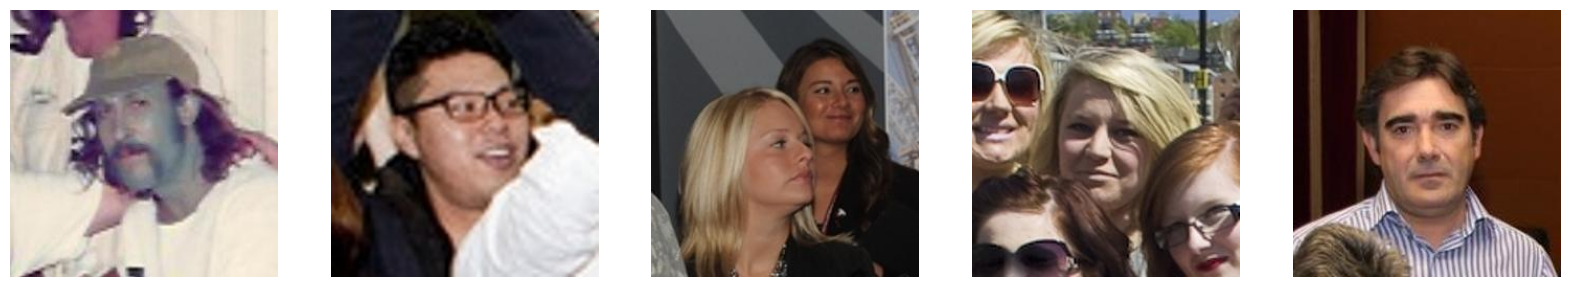

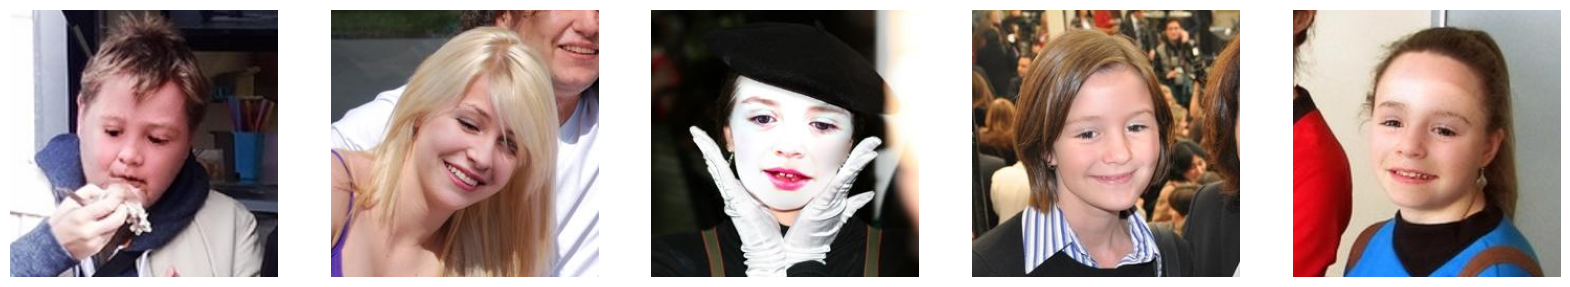

In [14]:
import os
import matplotlib.pyplot as plt
import cv2

def display_sample_images(image_path, n=5):
    categories = ['Real', 'Fake']
    for category in categories:
        folder = os.path.join(image_path, category)
        files = os.listdir(folder)[:n]
        fig, axes = plt.subplots(1, n, figsize=(20, 5))
        for i, file in enumerate(files):
            img = cv2.imread(os.path.join(folder, file))
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
        plt.show()

# Example usage
image_path = '/content/Dataset/Dataset/Train'  # Adjust to your dataset path
display_sample_images(image_path)


Checking Image Dimensions (Size Consistency)

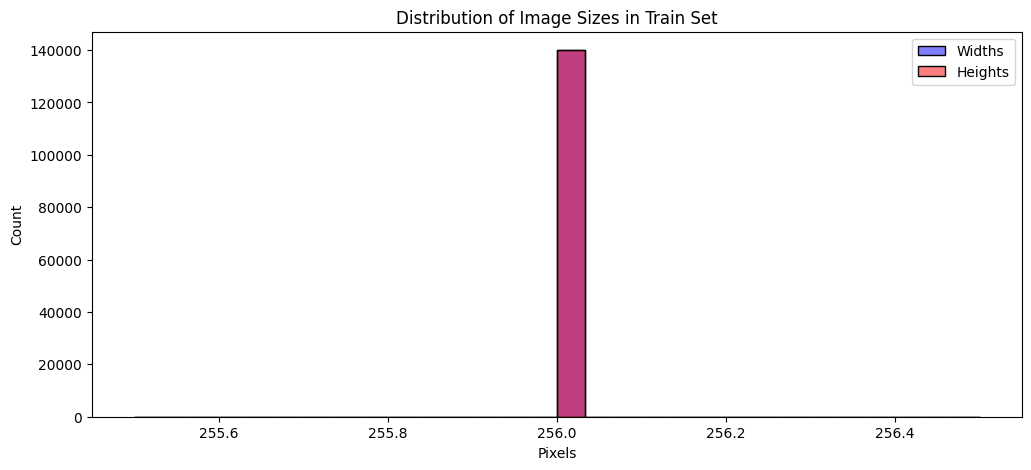

In [15]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def check_image_sizes(image_path):
    """
    Checks the dimensions of images in the dataset.
    """
    widths, heights = [], []

    for category in ['Real', 'Fake']:
        folder = os.path.join(image_path, category)
        for file in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, file))
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)

    return widths, heights

# Analyze train set image sizes
train_widths, train_heights = check_image_sizes("/content/Dataset/Dataset/Train")

# Plot distribution of image sizes
plt.figure(figsize=(12, 5))
sns.histplot(train_widths, bins=30, kde=True, color='blue', label="Widths")
sns.histplot(train_heights, bins=30, kde=True, color='red', label="Heights")
plt.legend()
plt.title("Distribution of Image Sizes in Train Set")
plt.xlabel("Pixels")
plt.show()


After visualizing the Image Sizes, we can see that all images have the same size of 256.0 pixels

Analyze Pixel Intensity Distribution

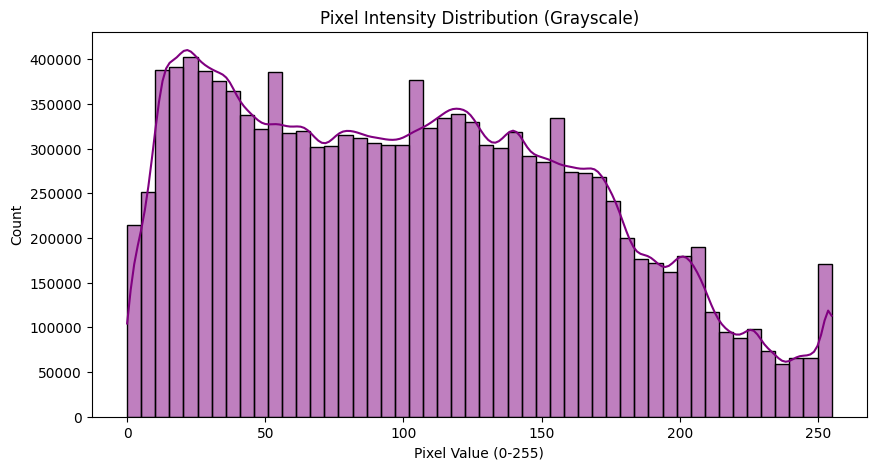

In [16]:
def analyze_pixel_distribution(image_path, sample_size=100):
    """
    Analyzes pixel intensity distribution for a sample of images.
    """
    pixel_values = []

    for category in ['Real', 'Fake']:
        folder = os.path.join(image_path, category)
        sample_files = np.random.choice(os.listdir(folder), sample_size, replace=False)

        for file in sample_files:
            img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            pixel_values.extend(img.flatten())  # Flatten and store pixel values

    return pixel_values

# Get pixel distributions
pixel_values = analyze_pixel_distribution("/content/Dataset/Dataset/Train")

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(pixel_values, bins=50, kde=True, color='purple')
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Value (0-255)")
plt.show()


Normalize images in the train folder

In [17]:
import os
import cv2
import numpy as np

def normalize_images_in_folder(folder_path):
    """
    Normalizes all images in a given folder by scaling pixel values to [0,1] and overwrites the images.
    """
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if the file is not an image

        # Normalize image
        img = img.astype(np.float32) / 255.0  # Convert range (0-255) to (0-1)

        # Convert back to uint8 (optional, for saving)
        img = (img * 255).astype(np.uint8)

        # Save normalized image
        cv2.imwrite(img_path, img)

# Define paths for real and fake folders in train set
train_real_path = "/content/Dataset/Dataset/Train/Real"
train_fake_path = "/content/Dataset/Dataset/Train/Fake"

# Apply normalization
normalize_images_in_folder(train_real_path)
normalize_images_in_folder(train_fake_path)

print("Normalization complete!")


Normalization complete!


# Statistical Test

In [18]:
from scipy.stats import chi2_contingency


def chi_square_test(train_counts, val_counts, test_counts):
    data = [
        [train_counts['Real'], train_counts['Fake']],
        [val_counts['Real'], val_counts['Fake']],
        [test_counts['Real'], test_counts['Fake']]
    ]
    chi2, p, dof, expected = chi2_contingency(data)
    print(f"Chi-Square statistic: {chi2}, p-value: {p}")

# Example usage
train_counts = count_images_in_folders('/content/Dataset/Dataset/Train')
val_counts = count_images_in_folders('/content/Dataset/Dataset/Validation')
test_counts = count_images_in_folders('/content/Dataset/Dataset/Test')

chi_square_test(train_counts, val_counts, test_counts)


Chi-Square statistic: 1.0893527079610823, p-value: 0.5800294771964867


The class distributions of "Real" vs. "Fake" images across Train, Validation, and Test sets are statistically similar.
No major dataset imbalance is present across these subsets.
You do not need to apply resampling techniques (such as oversampling or undersampling) to balance the class distributions.

# Hypothesis Evaluation

Checking if there is significate difference between real and fake images using t-statistics and p-value

In [19]:
from scipy import stats
import cv2
import os
import numpy as np

def evaluate_pixel_variance(image_folder):
    real_variances = []
    fake_variances = []

    # Paths to the Real and Fake subfolders
    real_folder = os.path.join(image_folder, 'Real')
    fake_folder = os.path.join(image_folder, 'Fake')

    # Iterate through real images
    for file in os.listdir(real_folder):
        img_path = os.path.join(real_folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            variance = np.var(img)
            real_variances.append(variance)

    # Iterate through fake images
    for file in os.listdir(fake_folder):
        img_path = os.path.join(fake_folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            variance = np.var(img)
            fake_variances.append(variance)

    # Perform t-test to compare the variances
    t_stat, p_val = stats.ttest_ind(real_variances, fake_variances)

    # Print the results
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Example usage
evaluate_pixel_variance('/content/Dataset/Dataset/Train')


T-statistic: -2.3197707699813797, P-value: 0.02035471188236814


### **Interpreting the T-Test Results:**

#### **Given Output:**
- **T-statistic:** -2.31977076998138
- **P-value:** 0.020354711882368124

#### **1. Null Hypothesis (H₀) and Alternative Hypothesis (H₁):**
- **H₀ (Null Hypothesis):** There is **no significant difference** in the pixel variances between the "Real" and "Fake" images.
- **H₁ (Alternative Hypothesis):** There is a **significant difference** in the pixel variances between the "Real" and "Fake" images.

#### **2. P-value Interpretation:**
- The **p-value = 0.0203** is **less than 0.05** (commonly used significance level).
- Since **p < 0.05**, we **reject the null hypothesis**. This suggests that there is a **statistically significant difference** in the pixel variances between the "Real" and "Fake" images.

#### **3. T-statistic Interpretation:**
- The **T-statistic = -2.32** means that the mean variance of the "Real" images is significantly lower than that of the "Fake" images.
- A **negative T-statistic** suggests that the mean pixel variance in "Real" images is smaller compared to the "Fake" images.

#### **Conclusion:**
- There is a **significant difference** in the pixel variances of "Real" and "Fake" images.
- The "Fake" images tend to have higher pixel variance than the "Real" images, which may be due to the manipulation or generation process in deepfake images, often introducing artifacts or inconsistencies.



In [20]:
import cv2
import os
import numpy as np

def preprocess_image(image, target_size=(224, 224)):
    """Resize and normalize the image."""
    # Resize the image
    resized_img = cv2.resize(image, target_size)

    # Normalize the image to range [0, 1]
    normalized_img = resized_img / 255.0  # Converts range from 0-255 to 0-1

    return normalized_img

def evaluate_pixel_variance_with_preprocessing(image_folder, target_size=(224, 224)):
    real_variances = []
    fake_variances = []

    # Paths to the Real and Fake subfolders
    real_folder = os.path.join(image_folder, 'Real')
    fake_folder = os.path.join(image_folder, 'Fake')

    # Iterate through real images
    for file in os.listdir(real_folder):
        img_path = os.path.join(real_folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            # Preprocess the image
            processed_img = preprocess_image(img, target_size)
            # Compute variance
            variance = np.var(processed_img)
            real_variances.append(variance)

    # Iterate through fake images
    for file in os.listdir(fake_folder):
        img_path = os.path.join(fake_folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            # Preprocess the image
            processed_img = preprocess_image(img, target_size)
            # Compute variance
            variance = np.var(processed_img)
            fake_variances.append(variance)

    # Perform t-test to compare the variances
    t_stat, p_val = stats.ttest_ind(real_variances, fake_variances)

    # Print the results
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Example usage
evaluate_pixel_variance_with_preprocessing('/content/Dataset/Dataset/Train')


T-statistic: -2.238421852184263, P-value: 0.02519512359103744


In an attempt to further explore why the differences in real and fake images, we resized and normalize the images to see if that will have an effect on the p-value and t-statistic

P-value Interpretation:
The p-value = 0.0252 is less than 0.05, meaning that we reject the null hypothesis.
Therefore, there is a statistically significant difference in the pixel variances between the "Real" and "Fake" images after preprocessing.

T-statistic Interpretation:
The T-statistic = -2.24 indicates that the mean pixel variance of "Real" images is significantly lower than that of "Fake" images after preprocessing.

In conclusion:
After applying preprocessing (resizing and normalization), the pixel variance between "Real" and "Fake" images is still significantly different.
The "Fake" images still have higher pixel variance than the "Real" images, even after normalization and resizing, which suggests that this difference may not just be due to the preprocessing steps, but potentially due to inherent characteristics of "Fake" images, such as artifacts introduced during generation.

**Practical Implication:** The difference in pixel variance could be a useful feature for a model designed to detect deepfakes, as it remains noticeable even after standard image preprocessing.